In [283]:
# mnist dataset is already heavily preprocessed. Just scale & split
# required.

In [284]:
import tensorflow as tf  # for creation & training of nn
import tensorflow_datasets as tfds   # to obtain mnist dataset

Downloading & Preprocessing data

In [285]:
# Parameters to be used later on-
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [286]:
mnist_dataset, mnist_info = tfds.load(name = 'mnist', with_info=True, as_supervised=True)

In [287]:
mnist_train, mnist_test = mnist_dataset['train'],mnist_dataset['test']

In [288]:
# In ML we like no's that are standardised in some way. So  technique in images is to scale pixel values b/w 0 and 1 which originally would be b/w 0 and 255 for greyscale.
# Divide all pixels in dataset by 255, so value will be b/w 0 & 1.

In [289]:
mnist_train

<PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [290]:
mnist_test

<PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [291]:
def scale(image, label):
    image = tf.cast(image,tf.float32)
    image /= 255.

    return image, label

In [292]:
# Scale every image in train and test dataset
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [293]:
# Validation set is crucial to prevent overfitting using early stopping
# Split training set manually to create a validation set (10% of
# training set)

In [294]:
mnist_info.splits['train'].num_examples

60000

In [295]:
mnist_info.splits['test'].num_examples

10000

In [296]:
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples

In [297]:
num_validation_samples

6000.0

In [298]:
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [299]:
# we need validation set to contain data with same distribution as training data

In [300]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [301]:
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [302]:
# Test Data
num_test_samples = mnist_info.splits['test'].num_examples

In [303]:
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [304]:
num_test_samples

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [305]:
# batch dataset for optimal performance of network
# batch size generally recommended in power of 2 (32,64,128) etc

# validation & test sets not necessarily be batched as we do not
# backward propagate on them however model expects them to be batched to get proper dimensions.

In [306]:
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

Build, Train and Test Network

In [307]:
# Define configuration of n/w
# Compile model
# Fit model on training data

In [308]:
# keras.sequential refers to fact that layers come 1 after another in sequence. argument for this is a list of all layers
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50,5,activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(50,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

In [309]:
model.summary(line_length = 60)
# 1st dimension is None in output shape cz all data is batched

Model: "sequential_4"
____________________________________________________________
 Layer (type)              Output Shape            Param #  
 conv2d_8 (Conv2D)         (None, 24, 24, 50)      1300     
                                                            
 max_pooling2d_8 (MaxPooli  (None, 12, 12, 50)     0        
 ng2D)                                                      
                                                            
 conv2d_9 (Conv2D)         (None, 10, 10, 50)      22550    
                                                            
 max_pooling2d_9 (MaxPooli  (None, 5, 5, 50)       0        
 ng2D)                                                      
                                                            
 flatten_4 (Flatten)       (None, 1250)            0        
                                                            
 dense_4 (Dense)           (None, 10)              12510    
                                                            
To

In [310]:
# Above model has 36,360 parameters all of which are trainable.
# Trainable parameters r weights of r n/w, the parameters that model is trying to learn. In our model this refers to different no's in the kernel & the final dense layer.
# parameters which should not be changed during learning process r non-trainable.

In [311]:
# Include softmax activation function in the loss function itself instead of dense layer

In [312]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

# The from_logits=True attribute inform the loss function that the output values generated by the model are not normalized, a.k.a. logits. In other words, the softmax function has not been applied on them to produce a probability distribution.

# if from_logits=False, means the input is a probability and usually you should have some softmax activation in your last layer.

In [313]:
# Compile model with loss function & optimizer

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [314]:
# To check overfitting, early stopping is the tool.
# In tensorflow, early stopping is a callback.
# Callbacks are functions that are called at the end of each epoch

In [315]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [316]:
model.fit(
    train_data,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_data,
    verbose = 2 # print info at end of each epoch
)

Epoch 1/20
422/422 - 19s - loss: 0.2743 - accuracy: 0.9202 - val_loss: 0.0795 - val_accuracy: 0.9753 - 19s/epoch - 45ms/step
Epoch 2/20
422/422 - 17s - loss: 0.0780 - accuracy: 0.9769 - val_loss: 0.0568 - val_accuracy: 0.9825 - 17s/epoch - 41ms/step
Epoch 3/20
422/422 - 18s - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.0377 - val_accuracy: 0.9888 - 18s/epoch - 43ms/step
Epoch 4/20
422/422 - 18s - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0357 - val_accuracy: 0.9875 - 18s/epoch - 43ms/step
Epoch 5/20
422/422 - 17s - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0325 - val_accuracy: 0.9905 - 17s/epoch - 41ms/step
Epoch 6/20
422/422 - 17s - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.0240 - val_accuracy: 0.9928 - 17s/epoch - 41ms/step
Epoch 7/20
422/422 - 17s - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.0163 - val_accuracy: 0.9947 - 17s/epoch - 41ms/step
Epoch 8/20
422/422 - 17s - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0278 - val_accuracy: 0.9908 - 17s/epoch - 41ms/step


Testing Model

In [317]:
# Evaluate network on test dataset

test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 710ms/step - loss: 0.0303 - accuracy: 0.9917


In [318]:
# Print result
print('loss-',round((test_loss),4))
prcnt = ((test_accuracy)*100)
print('accuracy-',round((prcnt),2))

loss- 0.0303
accuracy- 99.17


In [319]:
# Plotting images & results

In [320]:
import matplotlib.pyplot as plt
import numpy as np

In [321]:

# Split test data into 2 arrays, having images & labels

# .numpy() converts a tensor object into numpy.ndarray

for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape image into 28*28 form, suitable for matplotlib (original: 28*28*1)
images_plot = np.reshape(images_test, (10000,28,28))

In [322]:
images_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [323]:
labels_test

array([2, 0, 4, ..., 8, 0, 5], dtype=int64)

In [324]:
images_plot

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

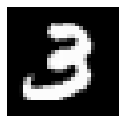

Label: 3


In [325]:
# Image to be displayed & tested
i = 26

# plot image
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap='gray', aspect='auto')
plt.show()

# print correct label for image
print("Label: {}".format(labels_test[i-1]))

In [326]:
# Obtain model's prediction (logits)
predictions = model.predict(images_test[i-1:i])

# convert prediction into probability
probabilities = tf.nn.softmax(predictions).numpy()
# convert probabilities to percentages
probabilities = probabilities*100

In [327]:
probabilities

array([[1.6325680e-13, 1.7127899e-14, 9.2045774e-11, 1.0000000e+02,
        4.1036546e-18, 4.8041175e-09, 9.6197015e-20, 2.0980051e-11,
        4.5936375e-08, 2.9962639e-06]], dtype=float32)

In [328]:
probabilities[0]


array([1.6325680e-13, 1.7127899e-14, 9.2045774e-11, 1.0000000e+02,
       4.1036546e-18, 4.8041175e-09, 9.6197015e-20, 2.0980051e-11,
       4.5936375e-08, 2.9962639e-06], dtype=float32)

<BarContainer object of 10 artists>

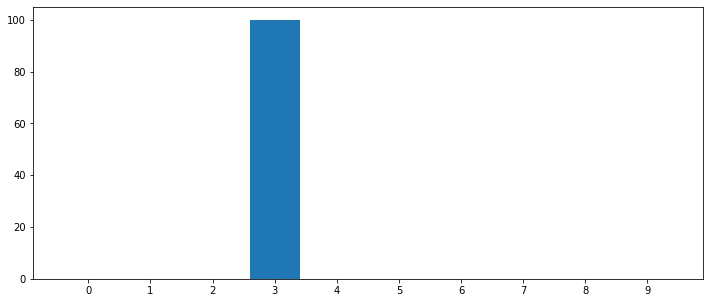

In [329]:
# create bar chart to plot probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0],
        tick_label = ["0","1","2","3","4","5","6","7","8","9"])

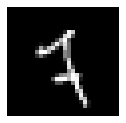

Label: 7


In [330]:
# Another test
# Image to be displayed & tested
i = 34

# plot image
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap='gray', aspect='auto')
plt.show()

# print correct label for image
print("Label: {}".format(labels_test[i-1]))

In [331]:
# Obtain model's prediction (logits)
predictions = model.predict(images_test[i-1:i])

# convert prediction into probability
probabilities = tf.nn.softmax(predictions).numpy()
# convert probabilities to percentages
probabilities = probabilities*100

In [332]:
probabilities

array([[1.1116971e-08, 8.9886894e+00, 5.2978821e+01, 1.2327422e+01,
        6.9462590e+00, 1.0008187e-01, 4.1932258e-06, 1.6649000e+01,
        2.4038556e-01, 1.7693368e+00]], dtype=float32)

<BarContainer object of 10 artists>

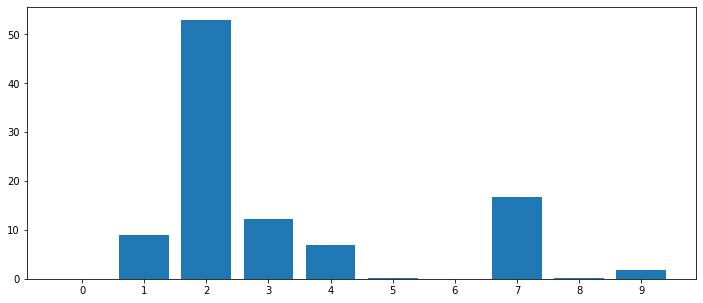

In [333]:
# create bar chart to plot probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0],
        tick_label = ["0","1","2","3","4","5","6","7","8","9"])